In [1]:
from IPython.display import Image as ipImage
import numpy as np
from PIL import Image
from collections import namedtuple

ImportError: No module named PIL

In [273]:
im = Image.open('whitepages/pdfs/whiteind-0.png').convert('L')

In [350]:
top = MaskedSection.PartitionMask(im)

In [351]:
children = top.children

In [345]:
[(x.top, x.bottom) for x in children]

[(0, 508), (530, 3079), (3116, 3299)]

In [346]:
children[1].bands

[498:516 => 18,
 874:899 => 25,
 1261:1282 => 21,
 1640:1666 => 26,
 2024:2049 => 25]

In [347]:
[(x.top, x.bottom) for x in children[1].children]

[(0, 498), (516, 874), (899, 1261), (1282, 1640), (1666, 2024), (2049, 3079)]

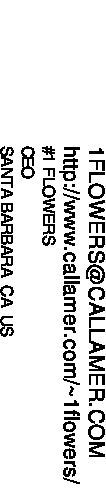

In [352]:
Image.fromarray(children[1].children[0].children[1].bits.astype('uint8')*255)

In [349]:
class Band:
    __slots__ = ('start', 'width')
    def __init__(self, first, last):
        self.first = first
        self.last = last
    
    @property
    def width(self):
        return self.last - self.first
    
    def is_eligible(self, context_width):
        if self.width < 1:
            return False
        if self.first == 0:
            return False
        if self.last == context_width-1:
            return False
        return True
    
    def __repr__(self):
        return "{}:{} => {}".format(self.first, self.last, self.width)
    
class MaskedSection:
    def __init__(self, parent, top, bottom, orientation=None, bits=None):
        self.parent = parent
        self.top = top
        self.bottom = bottom
        self._bands = []
        if parent:
            self.bits = parent.bits[top:bottom]
            self.orientation = self.parent.orientation * -1
            
            if self.orientation == -1:
                self.bits = self.rotate_fw(self.bits)
            else:
                self.bits = self.rotate_rv(self.bits)
        else:
            self.orientation = 1
            self.bits = bits
        
    @classmethod
    def PartitionMask(cls, im):
        bits = np.asarray(im, dtype='bool')
        return cls(parent=None, top=0, bottom=len(bits)-1, bits=bits)
        
    @property
    def children(self):
        _children = []
        top = 0
        for i, b in enumerate(self.bands):
            _children.append(MaskedSection(self, top, b.first+1))
            top = b.last
        _children.append(MaskedSection(self, b.last, self.bottom))
        return _children
            
    @property
    def context(self):
        if parent == None:
            return self.bits
        return self.parent.context
    
    @property
    def bands(self):
        if not self._bands:
            self._bands = self.find_bands(self.bits)
            self._bands = self.filter_bands(self._bands)
            self._bands = sorted(self._bands, key=lambda x: x.first)
        return self._bands
    
    @property
    def agg_bits(self):
        bits = np.array(self.bits, copy=True)
        for child in self.children:
            print child.top, child.bottom
            bits[child.top: child.bottom] &= child.agg_bits
        mask = self.mask
        bits &= mask
        if self.orientation == -1:
            bits = self.rotate_rv(bits)
        return bits
        
    @property
    def image(self):
        return Image.fromarray(self.agg_bits.astype('uint8')*255)
                
    @staticmethod
    def bander(bits):
        (rows, columns) = bits.shape
        blank_row = columns
        band = Band(first=0, last=0)
        for i in range(rows):
            if sum(bits[i]) < blank_row:
                if band.is_eligible(rows):
                    yield band
                band = Band(first=i, last=i)
            else:
                band.last = i
        
    @property
    def mask(self):
        _mask = np.ones_like(self.bits.shape, dtype='bool')        
        for b in self.bands:
            _mask[b.first:b.width] = 0
#             for i in range(b.width):
#                 _mask[b.first + i] = 0
        return _mask
    
    @staticmethod
    def make_mask(bands, orig):
        mask = np.ones_like(orig)
        for b in bands:
            for i in range(b.width):
                mask[b.first:i] = 0
        return mask
    
    @staticmethod
    def make_im(bits):
        return Image.fromarray(bits.astype('uint8')*255)
    
    @staticmethod
    def rotate_fw(bits):
        return np.rot90(bits, 3)
    
    @staticmethod
    def rotate_rv(bits):
        return np.rot90(bits, 1)
    
    @staticmethod
    def filter_bands(bands):
        return [x for x in bands if (bands[0].width * 1.0/ x.width) < 1.8]

    @staticmethod
    def find_bands(bits):
        bands = [x for x in MaskedSection.bander(bits)]
        ordered_bands = sorted(bands, key=lambda x: x.width, reverse=True)
        return ordered_bands


In [7]:
gs.transpose()

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [43]:
class Mask:
    def __init__(self, ary):
        self.ary = ary
        self.sections = SecTree()
        
    def build(self):
        for b in filtered_bands:
            for i in range(b.width):
                mask[b.first + i] = 0        
        

In [18]:
bands = [x for x in MaskedSection.bander(gs)]
bands

[198:207 => 9,
 508:530 => 22,
 554:558 => 4,
 577:582 => 5,
 646:649 => 3,
 846:849 => 3,
 2321:2322 => 1,
 3021:3024 => 3,
 3042:3044 => 2,
 3058:3065 => 7,
 3079:3116 => 37,
 3142:3157 => 15]

In [33]:
sorted_bands = sorted(bands, key=lambda x: x.width, reverse=True)

In [34]:
sorted_bands
[x for x in sorted_bands if x ]

[3079:3116 => 37,
 508:530 => 22,
 3142:3157 => 15,
 198:207 => 9,
 3058:3065 => 7,
 577:582 => 5,
 554:558 => 4,
 646:649 => 3,
 846:849 => 3,
 3021:3024 => 3,
 3042:3044 => 2,
 2321:2322 => 1]

In [59]:
x = 23.0
y = 26.0
import math
filtered_bands = [x for x in sorted_bands if math.sqrt( x.width / sorted_bands[0].width) > 0.9]

In [60]:
mask = np.ones_like(gs)

In [61]:
for b in filtered_bands:
    for i in range(b.width):
        mask[b.first + i] = 0

In [62]:
r = mask[3141]

In [75]:
sub_im_1 = gs[:508]
sub_im_2 = gs[530:3079]
sub_im_3 = gs[3116:]

In [111]:
sub_im_2_tr = np.rot90(sub_im_2, 3)
bands = [x for x in MaskedSection.bander(sub_im_2_tr)]
sorted_bands = sorted(bands, key=lambda x: x.width, reverse=True)
print sorted_bands
filtered_bands = [x for x in sorted_bands if math.sqrt( x.width / sorted_bands[0].width) > 0.2]
filtered_bands
[(math.sqrt(sorted_bands[0].width) - math.sqrt(x.width))**2 for x in sorted_bands]

[1640:1666 => 26, 874:899 => 25, 2024:2049 => 25, 1261:1282 => 21, 498:516 => 18]


[0.0,
 0.009804864072151632,
 0.009804864072151632,
 0.2667142178083094,
 0.7333846944321285]

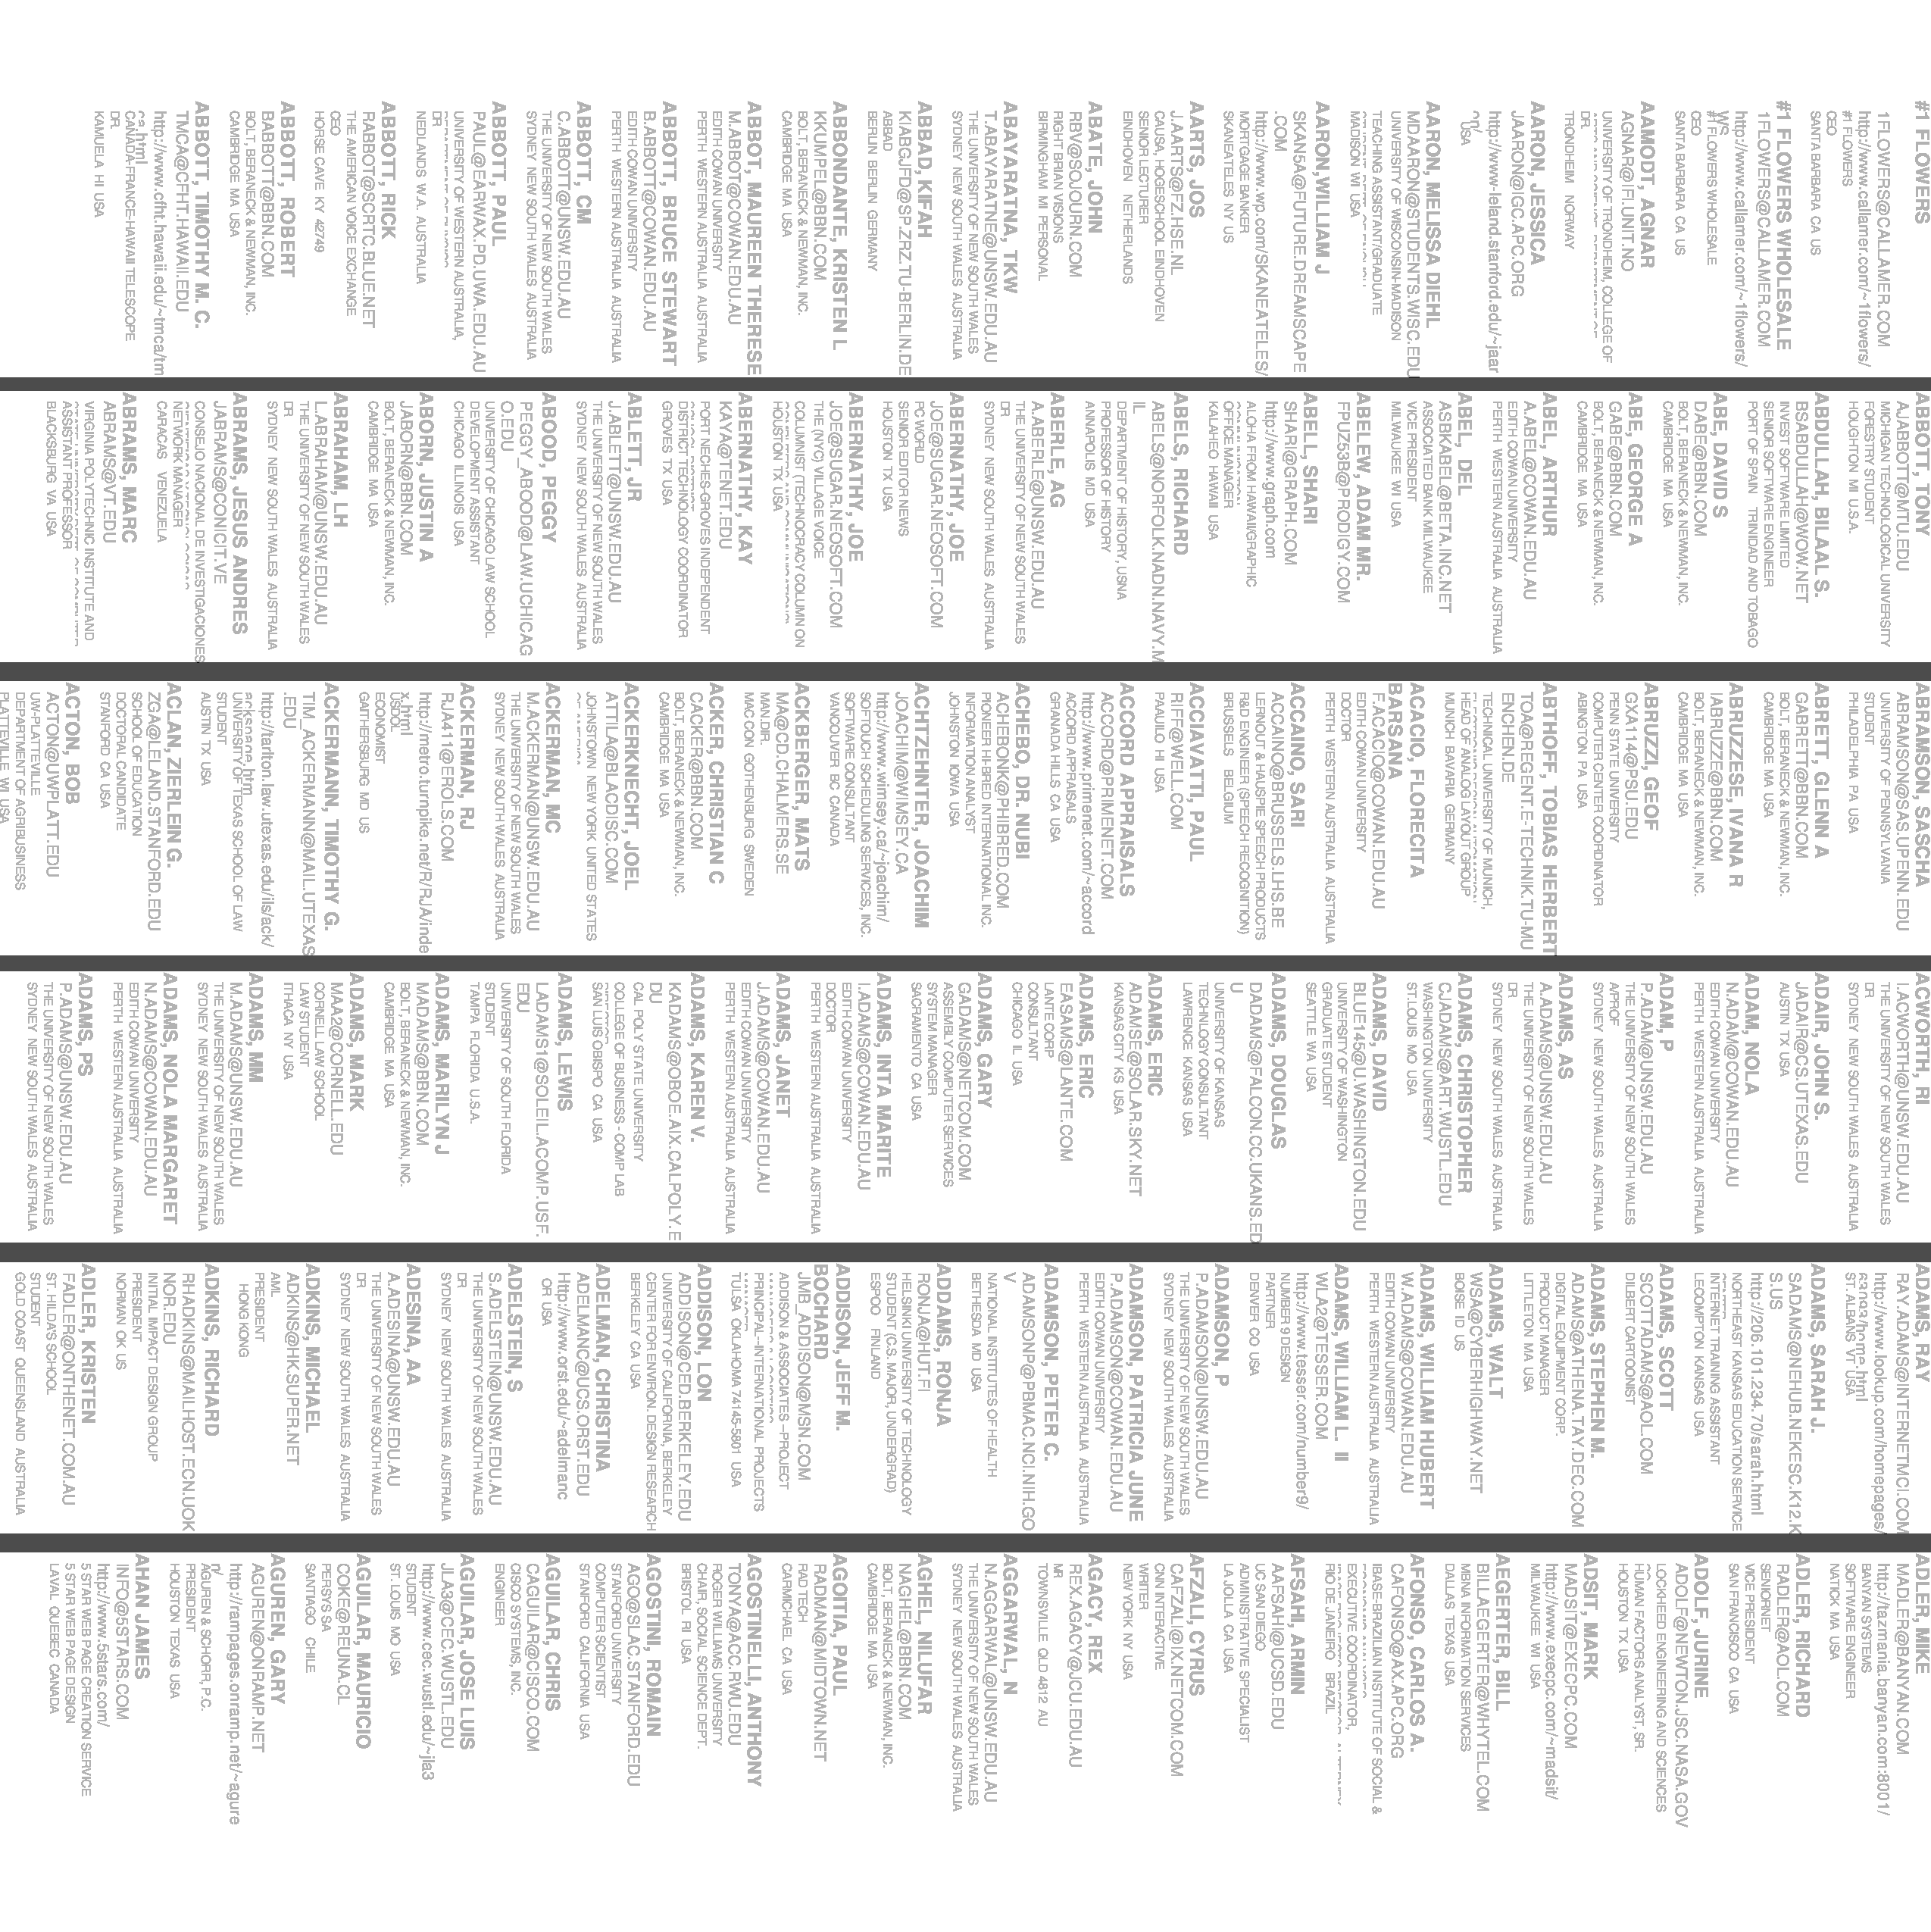

In [176]:
MaskedSection.make_im(sub_im_2_tr)
bands = MaskedSection.find_bands(sub_im_2_tr)
filtered = MaskedSection.filter_bands(bands)
mask = MaskedSection.make_mask(filtered, sub_im_2_tr)
mask_im = MaskedSection.make_im(mask)
im = MaskedSection.make_im(sub_im_2_tr)
im = Image.fromarray(sub_im_2_tr)
Image.blend(mask_im, im, 0.3)

In [145]:
sorts = [126.1, 125.9, 124.9, 111.5, 1011, 1]
print [(sorts[0]) / x for x in sorts]
[x for x in bands if (bands[0].width/ x.width) > 1]

[1.0, 1.0015885623510723, 1.009607686148919, 1.1309417040358745, 0.12472799208704252, 126.1]


[]

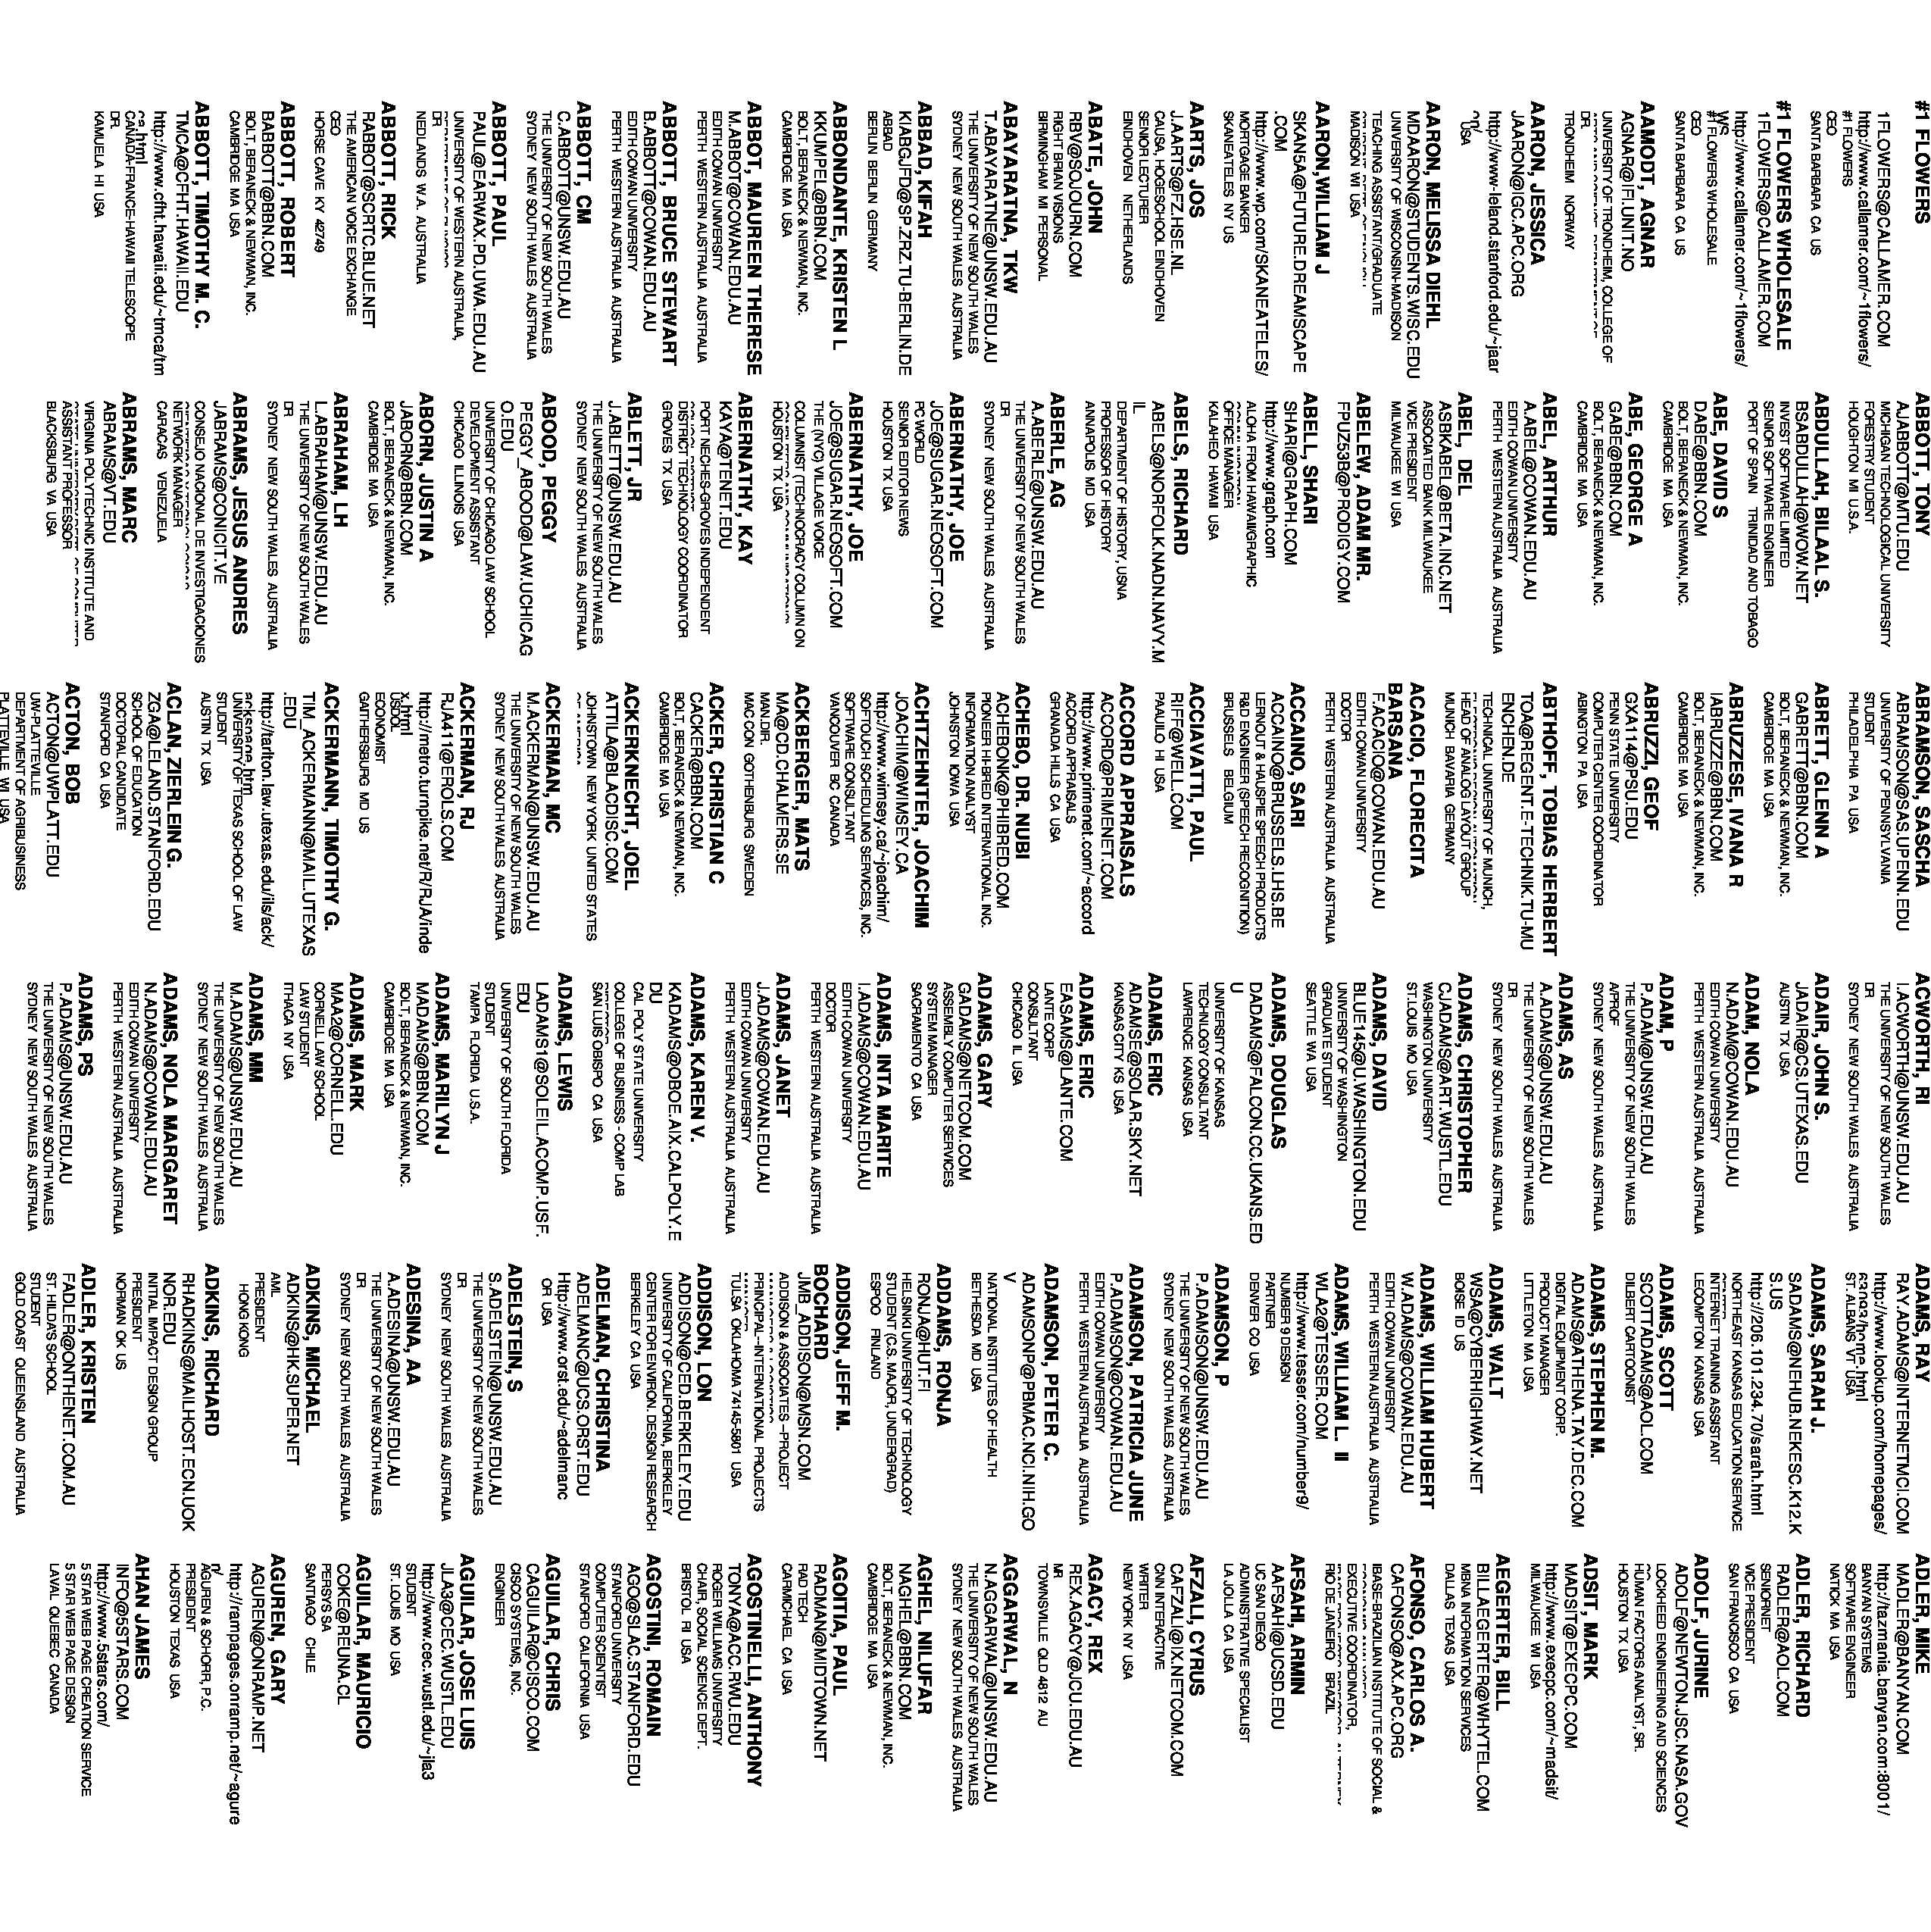

In [80]:
Image.fromarray(sub_im_2_tr.astype('uint8'))

In [63]:
mask_im = Image.fromarray(mask.astype('uint8')*255)

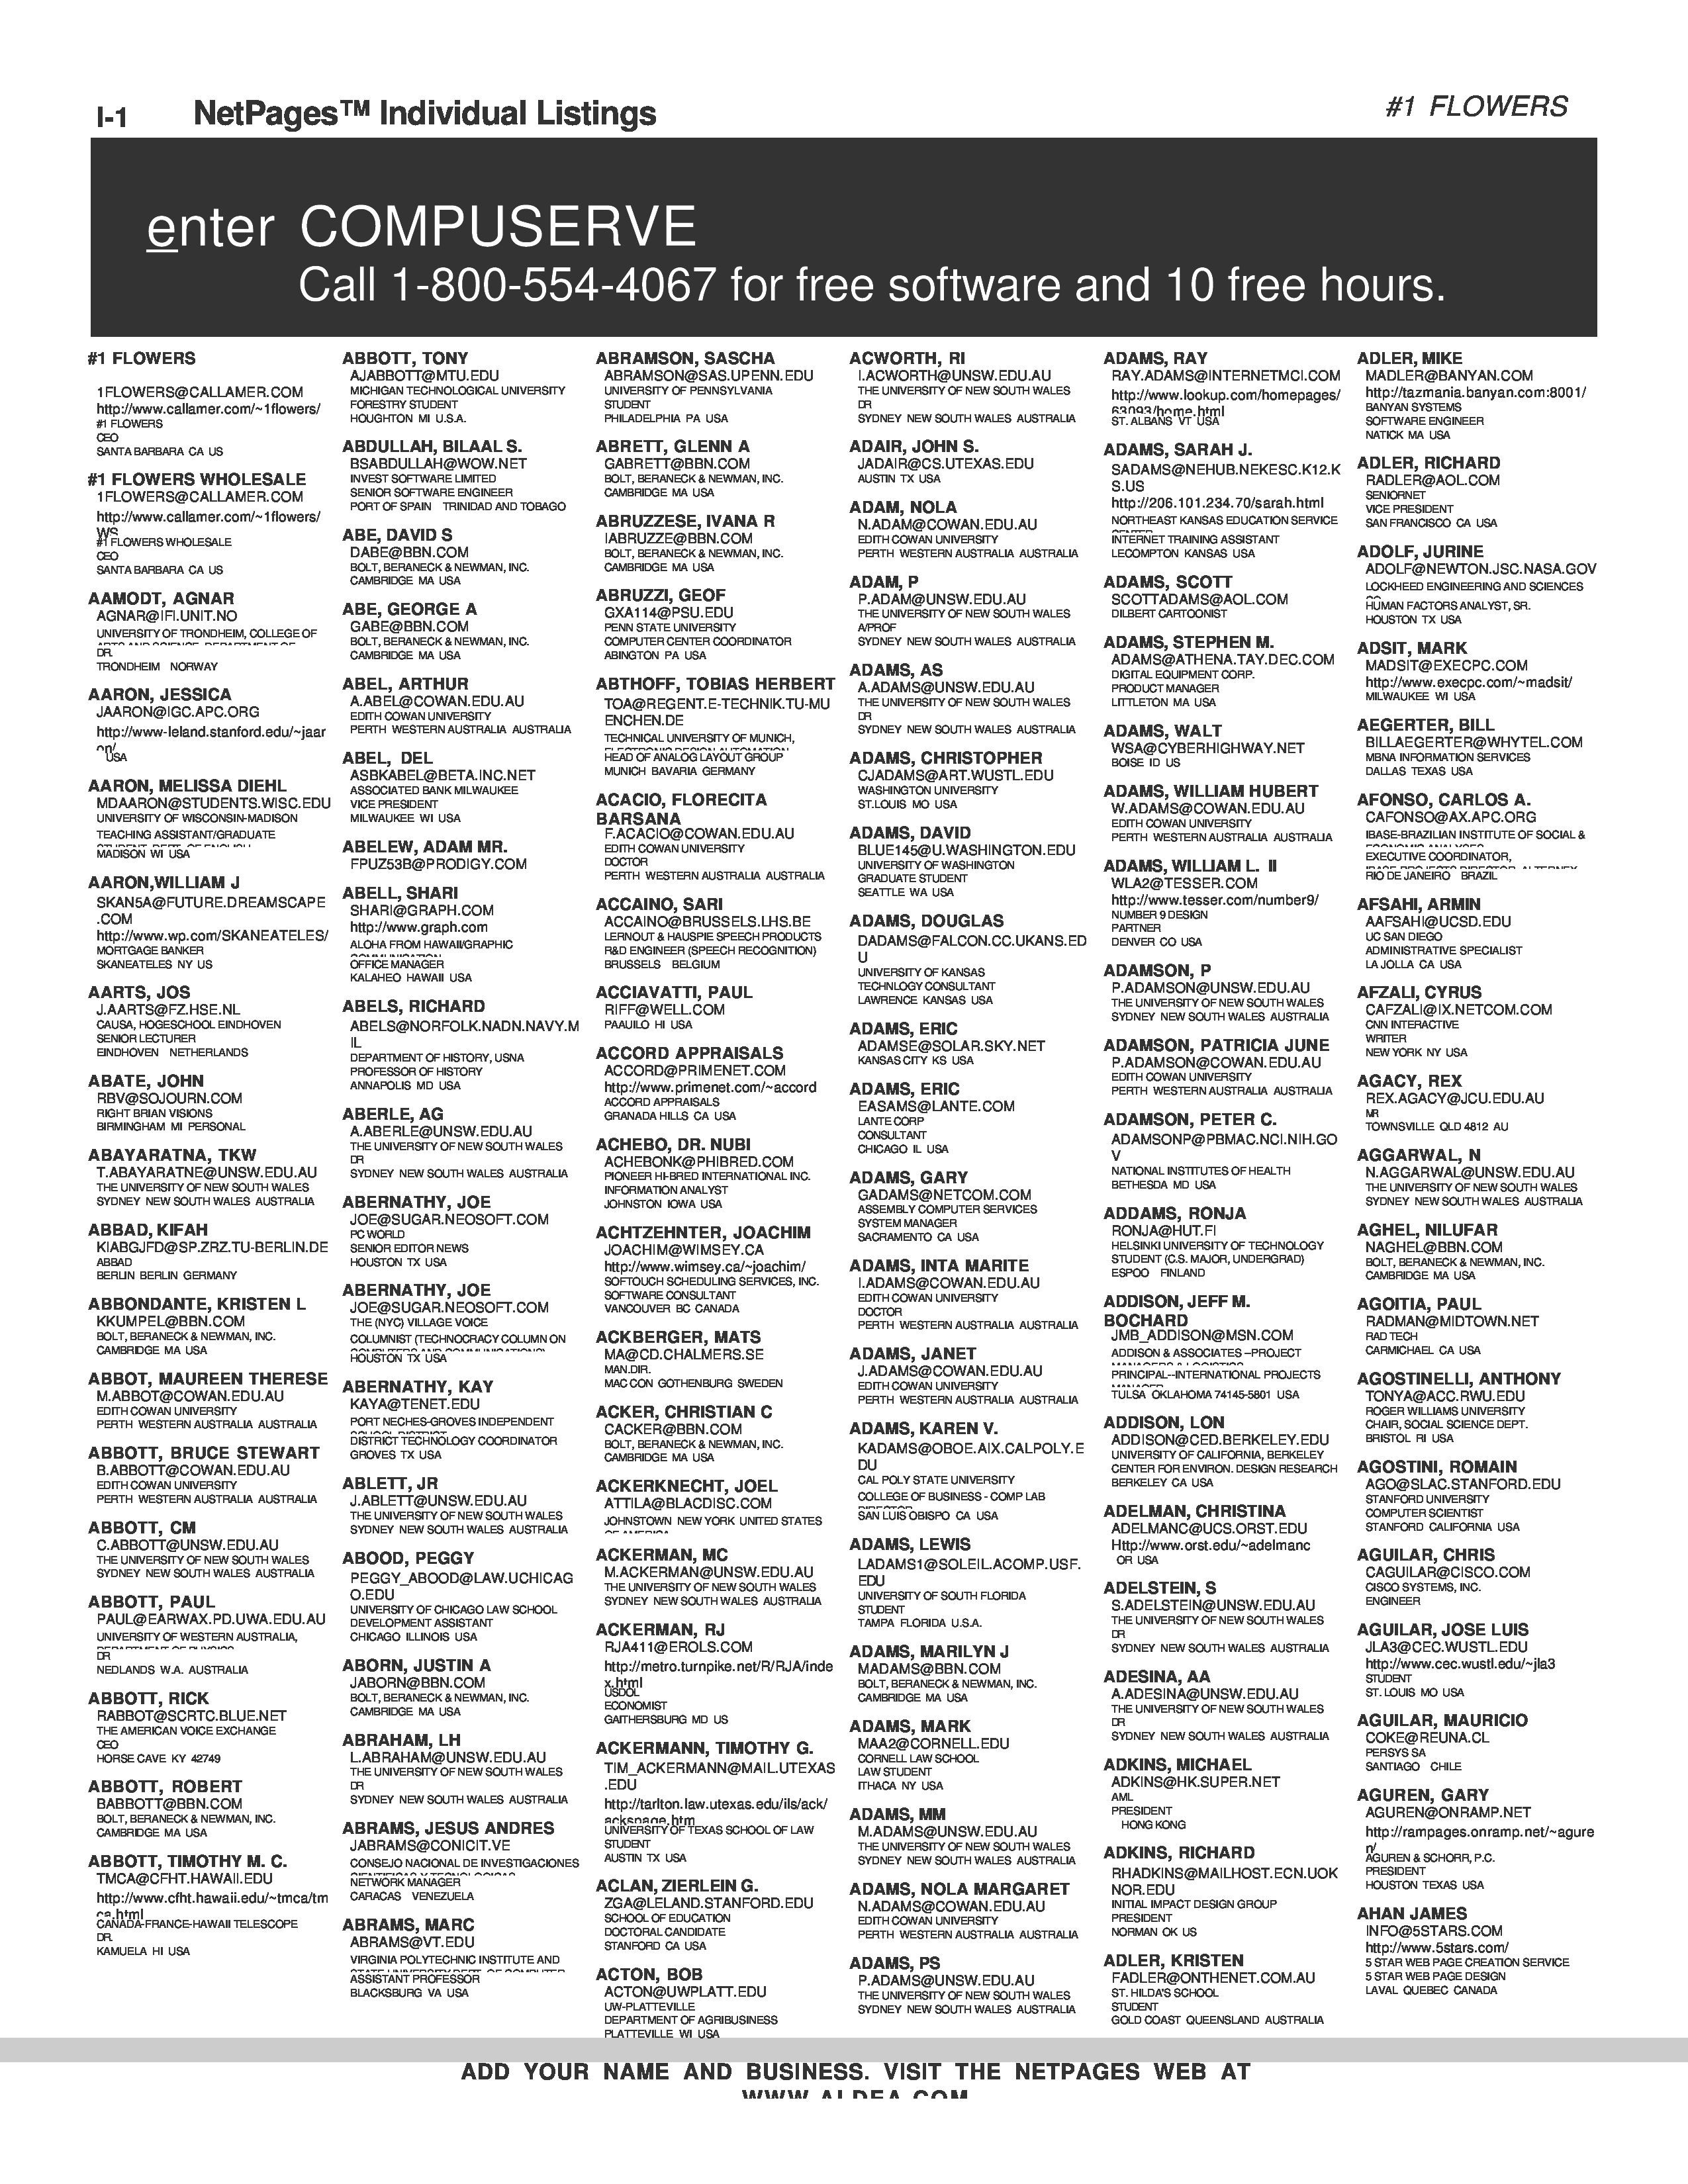

In [64]:
Image.blend(im, mask_im, 0.2)